In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Elmovo rentals

In [2]:
elmovo_loc = os.path.join(os.getcwd(), 'Elmovo_rentals_12-1-2020.csv')
elmovo = pd.read_csv(elmovo_loc)
#elmovo.head()
elmovo.price_for_driving_gross.describe()

count    4631.000000
mean       10.912926
std        16.496332
min         0.000000
25%         9.000000
50%        11.000000
75%        11.000000
max       759.000000
Name: price_for_driving_gross, dtype: float64

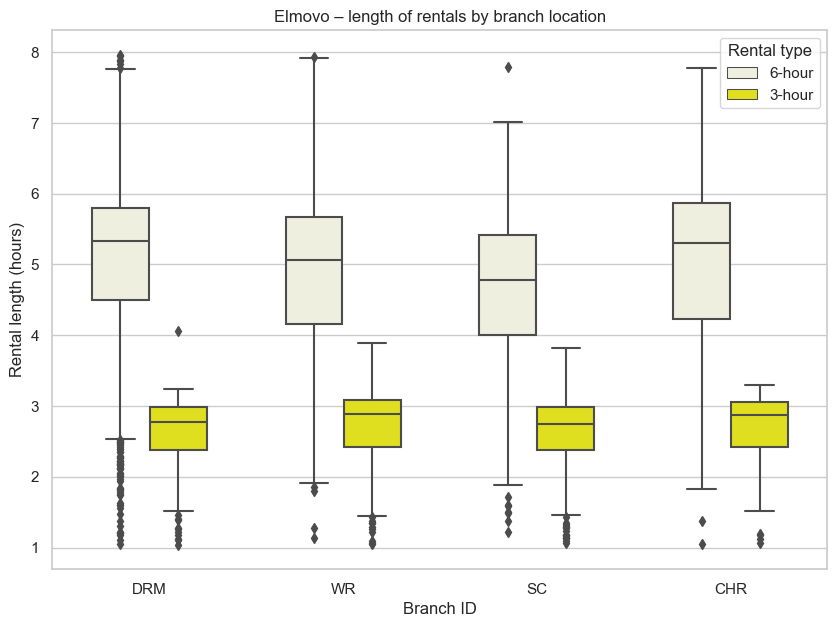

In [7]:
elmovo['rental_length'] = elmovo['time_driving']/3600 + elmovo['time_parking']/3600

#Simple split into 2 categories
#elmovo['rental_type'] = '3-hour'
#elmovo.loc[elmovo['rental_length'] > 3, 'rental_type'] = '6-hour'

#More bands possible with np.select
conditions = [
    (elmovo['price_for_driving_gross'] < 9),
    (elmovo['price_for_driving_gross'] >= 9)
]
values = ['3-hour', '6-hour']
elmovo['rental_type'] = np.select(conditions, values)

elmovo = elmovo[(elmovo['rental_length'] > 1) & (elmovo['rental_length'] < 8)]
elmovo = elmovo[elmovo.branch_id.isin([4,6,7,8])]
elmovo.rental_type.describe()

sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
ax = sns.boxplot(data = elmovo, y='rental_length', x='branch_id', color='yellow', hue='rental_type', width=.6)
ax.set_xticklabels(['DRM', 'WR', 'SC', 'CHR'])
ax.set(xlabel='Branch ID', ylabel='Rental length (hours)')
plt.legend(loc='upper right', title='Rental type')
plt.title('Elmovo – length of rentals by branch location')
plt.savefig('rental_length.png', dpi=220)

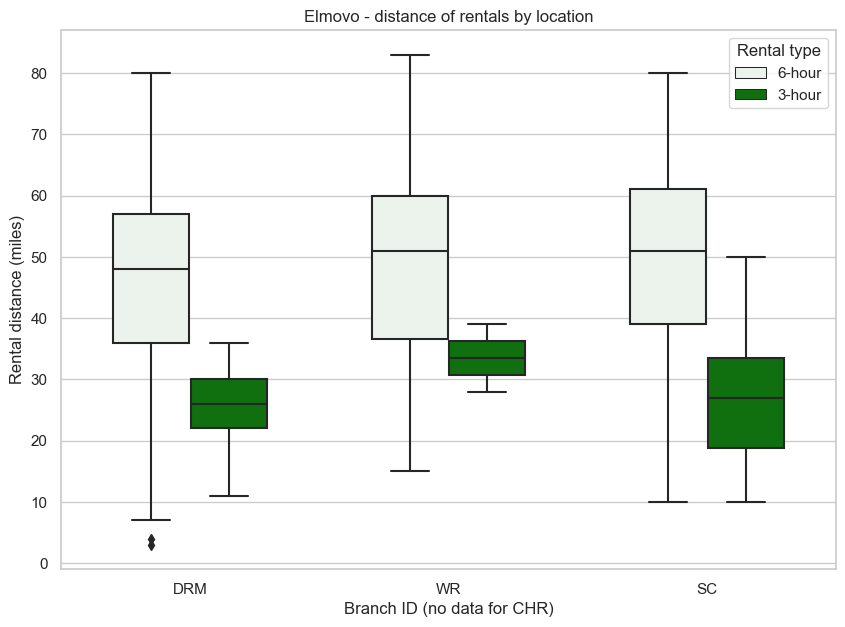

In [11]:
elmovo['rental_distance'] = elmovo['end_kilometers'] - elmovo['start_kilometers']

#elmovo['rental_type'] = '3-hour'
#elmovo.loc[elmovo['rental_length'] > 3, 'rental_type'] = '6-hour'

elmovo = elmovo[(elmovo['rental_distance'] > 0)]
elmovo = elmovo[elmovo.branch_id.isin([4,6,7])]
#elmovo.rental_type.describe()

sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
ax = sns.boxplot(data = elmovo, y='rental_distance', x='branch_id', color='green', hue='rental_type', width=.6)
ax.set_xticklabels(['DRM', 'WR', 'SC'])
ax.set(xlabel='Branch ID (no data for CHR)', ylabel='Rental distance (miles)')
plt.legend(loc='upper right', title='Rental type')
plt.title('Elmovo - distance of rentals by location')
plt.savefig('elmovo_rental_distance.png', dpi=220)

count    727.000000
mean      16.720770
std        3.169743
min        8.000000
25%       14.000000
50%       18.000000
75%       19.000000
max       23.000000
Name: start_hour, dtype: float64


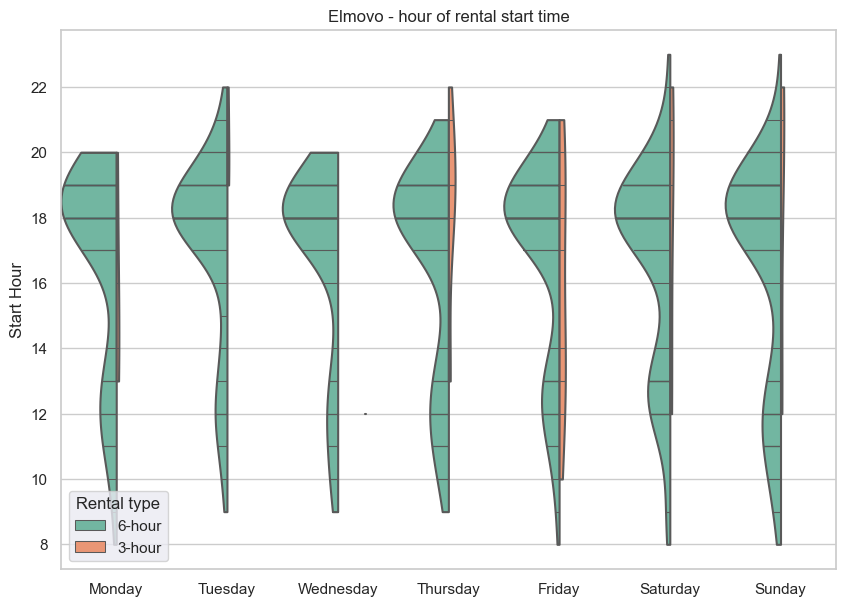

In [9]:

#elmovo.start_time.describe()
elmovo['start_time'] = pd.to_datetime(elmovo['start_time'], format='%Y-%m-%d %H:%M:%S')
elmovo['start_day'] = elmovo['start_time'].dt.day_name()
elmovo['start_hour'] = elmovo['start_time'].dt.hour
print(elmovo.start_hour.describe())
sns.violinplot(data=elmovo, x='start_day', y='start_hour', cut=0, hue='rental_type', palette='Set2', scale='count', inner='stick', width= 1, split=True, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.set(rc={"figure.figsize":(10, 7)})
plt.xlabel(None) 
plt.ylabel('Start Hour')
plt.legend(loc='lower left', title='Rental type')
plt.title('Elmovo - hour of rental start time')
plt.savefig('elmovo_rental_start_time.png', dpi=220)